In [173]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import re
import unicodedata
import io
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import svm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
import os
import sys

base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'RawData')

#Source File Path
#in_data_pref = os.path.join(data_dir, 'Input')
src_file_name = 'InterviewDat.csv'
src_data_path = os.path.join(data_dir , src_file_name)

In [175]:
#Read raw source file for inteview
df_raw = pd.read_csv(src_data_path, index_col=None, parse_dates=["SchedulingDay", "InterviewDay"], infer_datetime_format=True)

In [176]:
df_raw.head()

,CandidateId,InterviewID,Gender,SchedulingDay,InterviewDay,Candidate Current Location,Candidate Job Location,Interview Venue,Candidate Native location,JobVsNative,Have you obtained the necessary permission to start at the required time,Hope there will be no unscheduled meetings,Can I Call you three hours before the interview and follow up on your attendance for the interview,Can I have an alternative number/ desk number. I assure you that I will not trouble you too much,Have you taken a printout of your updated resume. Have you read the JD and understood the same,Are you clear with the venue details and the landmark.,Has the call letter been shared,Confirmed,Attended
0,1,5642903,F,2016-04-29 18:38:08,2016-04-29,Chennai,Hosur,Hosur,Hosur,True,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes
1,2,5642503,M,2016-04-29 16:08:27,2016-04-29,Chennai,Bangalore,Hosur,Trichy,False,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,3,5642549,F,2016-04-29 16:19:04,2016-04-29,Chennai,Chennai,Hosur,Chennai,True,NaN,Na,NaN,NaN,NaN,NaN,NaN,No,Yes
3,4,5642828,F,2016-04-29 17:29:31,2016-04-29,Chennai,Chennai,Hosur,Chennai,True,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes
4,5,5642494,F,2016-04-29 16:07:23,2016-04-29,Chennai,Bangalore,Hosur,Chennai,False,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes


In [75]:
df_raw["days_delta"] = (df_raw.InterviewDay - pd.to_datetime(df_raw.SchedulingDay.dt.date)).dt.days

In [76]:
#Renaming the columns
df_raw.columns

Index(['CandidateId', 'InterviewID', 'Gender', 'SchedulingDay', 'InterviewDay',
       'Candidate Current Location', 'Candidate Job Location',
       'Interview Venue', 'Candidate Native location', 'JobVsNative',
       'Have you obtained the necessary permission to start at the required time',
       'Hope there will be no unscheduled meetings',
       'Can I Call you three hours before the interview and follow up on your attendance for the interview',
       'Can I have an alternative number/ desk number. I assure you that I will not trouble you too much',
       'Have you taken a printout of your updated resume. Have you read the JD and understood the same',
       'Are you clear with the venue details and the landmark.',
       'Has the call letter been shared', 'Confirmed', 'Attended',
       'days_delta'],
      dtype='object')

In [77]:
# Renaming variables to strings that are a little easier to work with.
df_raw.columns = ['Candidate_Id', 'Interview_ID', 'Gender', 'Scheduled_Day', 'Interview_Day',
                        'Cand_Loc', 'Job_Loc', 'Venue','Native_Loc','JobVsNative',
                         'Permission(Y/N)', 'MeetingConflict(Y/N)', 'PriorCall(Y/N)', 'AlterantePhone(Y/N)',
                        'ResumePrintout(Y/N)', 'VenueClarification(Y/N)', 'SharedLetter(Y/N)', 'Confirmed', 'Attended',
                         'days_delta']

In [78]:
df_raw

,Candidate_Id,Interview_ID,Gender,Scheduled_Day,Interview_Day,Cand_Loc,Job_Loc,Venue,Native_Loc,JobVsNative,Permission(Y/N),MeetingConflict(Y/N),PriorCall(Y/N),AlterantePhone(Y/N),ResumePrintout(Y/N),VenueClarification(Y/N),SharedLetter(Y/N),Confirmed,Attended,days_delta
0,1,5642903,F,2016-04-29 18:38:08,2016-04-29,Chennai,Hosur,Hosur,Hosur,True,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,0
1,2,5642503,M,2016-04-29 16:08:27,2016-04-29,Chennai,Bangalore,Hosur,Trichy,False,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
2,3,5642549,F,2016-04-29 16:19:04,2016-04-29,Chennai,Chennai,Hosur,Chennai,True,NaN,Na,NaN,NaN,NaN,NaN,NaN,No,Yes,0
3,4,5642828,F,2016-04-29 17:29:31,2016-04-29,Chennai,Chennai,Hosur,Chennai,True,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Yes,0
4,5,5642494,F,2016-04-29 16:07:23,2016-04-29,Chennai,Bangalore,Hosur,Chennai,False,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes,0
5,6,5626772,F,2016-04-27 08:36:51,2016-04-29,Gurgaon,Gurgaon,Gurgaon,Gurgaon,True,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
6,7,5630279,F,2016-04-27 15:05:12,2016-04-30,Gurgaon,Gurgaon,Gurgaon,Gurgaon,True,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,3
7,8,5630575,F,2016-04-27 15:39:58,2016-04-30,Gurgaon,Gurgaon,Gurgaon,Noida,False,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,3
8,9,5638447,F,2016-04-29 08:02:16,2016-04-29,Gurgaon,Gurgaon,Gurgaon,Delhi /NCR,False,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
9,10,5629123,F,2016-04-27 12:48:25,2016-04-29,Gurgaon,Gurgaon,Gurgaon,Delhi /NCR,False,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2


In [79]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 30)

In [80]:
df_raw['Cand_Loc'].replace(['- cochin-'],['cochin'], inplace = True)
df_raw['Job_Loc'].replace(['- cochin-'],['cochin'], inplace = True)
df_raw['Venue'].replace(['- cochin-'],['cochin'], inplace = True)
df_raw['Permission(Y/N)'].replace(['na', 'not yet', 'yet to confirm'],['nan', 'tbd', 'tbd'], inplace = True)
df_raw['MeetingConflict(Y/N)'].replace(['na', 'not sure', 'cant say'],['nan', 'unsure', 'unsure'], inplace = True)
df_raw['PriorCall(Y/N)'].replace(['na', 'no dont'],['nan', 'no'], inplace = True)
df_raw['MeetingConflict(Y/N)'].replace(['na', 'not sure', 'cant say'], ['nan', 'unsure', 'unsure'], inplace = True)
df_raw['AlterantePhone(Y/N)'].replace(['na', 'no i have only thi number'], ['nan', 'no'], inplace = True)
df_raw['ResumePrintout(Y/N)'].replace(['na', 'not yet', 'no- will take it soon'], ['nan', 'ny', 'ny'], inplace = True)
df_raw['VenueClarification(Y/N)'].replace(['na', 'no- i need to check'], ['nan', 'no'], inplace = True)
df_raw['SharedLetter(Y/N)'].replace(['na', 'not sure', 'need to check', 'not yet', 'yet to check','havent checked'],
['nan', 'unsure', 'unsure', 'unsure', 'unsure', 'unsure'], inplace = True)
df_raw['Confirmed'].replace(['Yes', 'No'],[1, 0], inplace = True)
df_raw['Attended'].replace(['Yes', 'No'],[1, 0], inplace = True)

In [81]:
df_raw.columns

Index(['Candidate_Id', 'Interview_ID', 'Gender', 'Scheduled_Day',
       'Interview_Day', 'Cand_Loc', 'Job_Loc', 'Venue', 'Native_Loc',
       'JobVsNative', 'Permission(Y/N)', 'MeetingConflict(Y/N)',
       'PriorCall(Y/N)', 'AlterantePhone(Y/N)', 'ResumePrintout(Y/N)',
       'VenueClarification(Y/N)', 'SharedLetter(Y/N)', 'Confirmed', 'Attended',
       'days_delta'],
      dtype='object')

In [82]:
df_raw['Permission(Y/N)'].replace({'Yes':1, 'No':0}, inplace=True)
df_raw['MeetingConflict(Y/N)'].replace({'Yes':1, 'No':0}, inplace=True)
df_raw['PriorCall(Y/N)'].replace({'Yes':1, 'No':0}, inplace=True)
df_raw['AlterantePhone(Y/N)'].replace({'Yes':1, 'No':0}, inplace=True)
df_raw['ResumePrintout(Y/N)'].replace({'Yes':1, 'No':0}, inplace=True)
df_raw['VenueClarification(Y/N)'].replace({'Yes':1, 'No':0}, inplace=True)
df_raw['SharedLetter(Y/N)'].replace({'Yes':1, 'No':0, 'unsure':np.nan}, inplace=True)
df_raw['JobVsNative'].replace({True:1, False:0}, inplace=True)

In [83]:
df_raw['Permission(Y/N)'].replace({'Yes':1, 'No':0,'Yet to confirm':np.nan, 'NO':0, 'yes':1, 'Na':np.nan,'Not yet':np.nan}, inplace=True)
df_raw['MeetingConflict(Y/N)'].replace({'Yes':1, 'No':0,'Not Sure':np.nan, 'Not sure':np.nan, 'yes':1, 'Na':np.nan,'cant Say':np.nan}, inplace=True)
df_raw['PriorCall(Y/N)'].replace({'Yes':1, 'No':0,'yes':1, 'Na':np.nan,'No Dont':np.nan}, inplace=True)
df_raw['AlterantePhone(Y/N)'].replace({'Yes':1, 'No':0,'yes':1, 'Na':np.nan,'No I have only thi number':0,'nan':np.nan}, inplace=True)
df_raw['ResumePrintout(Y/N)'].replace({'Yes':1, 'No':0,'yes':1, 'Na':np.nan,'No- will take it soon':0,'nan':np.nan,'Not Yet':0,'Not yet':0}, inplace=True)
df_raw['VenueClarification(Y/N)'].replace({'Yes':1, 'No':0,'yes':1, 'Na':np.nan,'No- I need to check':0,'nan':np.nan,'Not Yet':0,'Not yet':0,'Na':0,'no':0}, inplace=True)
df_raw['SharedLetter(Y/N)'].replace({'Yes':1, 'No':0,'yes':1, 'Na':np.nan,'Havent Checked':np.nan,'Need To Check':np.nan, 'Not sure':np.nan,'Yet to Check':np.nan,'Not Sure':np.nan,'nan':np.nan,'Not yet':np.nan,'Not Yet':0,'Not yet':0,'Na':0,'no':0}, inplace=True)

In [84]:
categorical_features = ['Cand_Loc','Job_Loc','Venue','Native_Loc','Gender']
boolean_features = ['JobVsNative','Permission(Y/N)','MeetingConflict(Y/N)','PriorCall(Y/N)','AlterantePhone(Y/N)','ResumePrintout(Y/N)','VenueClarification(Y/N)','SharedLetter(Y/N)','Confirmed']

for feature in boolean_features:
    df_raw[feature] = df_raw[feature].astype("bool")

for feature in categorical_features:
    df_raw[feature] = df_raw[feature].astype("category")

In [85]:
df_raw['Permission(Y/N)'].replace({True:1, False:0}, inplace=True)
df_raw['MeetingConflict(Y/N)'].replace({True:1, False:0}, inplace=True)
df_raw['PriorCall(Y/N)'].replace({True:1, False:0}, inplace=True)
df_raw['AlterantePhone(Y/N)'].replace({True:1, False:0}, inplace=True)
df_raw['ResumePrintout(Y/N)'].replace({True:1, False:0}, inplace=True)
df_raw['VenueClarification(Y/N)'].replace({True:1, False:0}, inplace=True)
df_raw['SharedLetter(Y/N)'].replace({True:1, False:0}, inplace=True)
df_raw['JobVsNative'].replace({True:1, False:0}, inplace=True)
df_raw['Confirmed'].replace({True:1, False:0}, inplace=True)

In [86]:
df_raw

,Candidate_Id,Interview_ID,Gender,Scheduled_Day,Interview_Day,Cand_Loc,Job_Loc,Venue,Native_Loc,JobVsNative,Permission(Y/N),MeetingConflict(Y/N),PriorCall(Y/N),AlterantePhone(Y/N),ResumePrintout(Y/N),VenueClarification(Y/N),SharedLetter(Y/N),Confirmed,Attended,days_delta
0,1,5642903,F,2016-04-29 18:38:08,2016-04-29,Chennai,Hosur,Hosur,Hosur,1,1,1,1,1,1,1,1,0,1,0
1,2,5642503,M,2016-04-29 16:08:27,2016-04-29,Chennai,Bangalore,Hosur,Trichy,0,1,1,1,1,1,1,1,1,1,0
2,3,5642549,F,2016-04-29 16:19:04,2016-04-29,Chennai,Chennai,Hosur,Chennai,1,1,1,1,1,1,1,1,0,1,0
3,4,5642828,F,2016-04-29 17:29:31,2016-04-29,Chennai,Chennai,Hosur,Chennai,1,1,1,0,1,0,1,1,1,1,0
4,5,5642494,F,2016-04-29 16:07:23,2016-04-29,Chennai,Bangalore,Hosur,Chennai,0,1,1,1,0,1,1,1,0,1,0
5,6,5626772,F,2016-04-27 08:36:51,2016-04-29,Gurgaon,Gurgaon,Gurgaon,Gurgaon,1,1,1,1,1,1,1,1,1,1,2
6,7,5630279,F,2016-04-27 15:05:12,2016-04-30,Gurgaon,Gurgaon,Gurgaon,Gurgaon,1,1,1,1,1,1,1,1,1,1,3
7,8,5630575,F,2016-04-27 15:39:58,2016-04-30,Gurgaon,Gurgaon,Gurgaon,Noida,0,1,1,1,1,1,1,1,1,1,3
8,9,5638447,F,2016-04-29 08:02:16,2016-04-29,Gurgaon,Gurgaon,Gurgaon,Delhi /NCR,0,1,1,1,1,1,1,1,1,1,0
9,10,5629123,F,2016-04-27 12:48:25,2016-04-29,Gurgaon,Gurgaon,Gurgaon,Delhi /NCR,0,1,1,1,1,1,1,1,1,1,2


In [87]:
one_hot_features = pd.get_dummies(df_raw.drop(["Candidate_Id","Interview_ID","Scheduled_Day","Interview_Day","Native_Loc","Venue","Job_Loc","Cand_Loc","Native_Loc","Gender","Attended"], axis=1)).columns

In [21]:
one_hot_features

Index(['JobVsNative', 'Permission(Y/N)', 'MeetingConflict(Y/N)',
       'PriorCall(Y/N)', 'AlterantePhone(Y/N)', 'ResumePrintout(Y/N)',
       'VenueClarification(Y/N)', 'SharedLetter(Y/N)', 'Confirmed',
       'days_delta'],
      dtype='object')

In [88]:
X = pd.get_dummies(df_raw.drop(["Candidate_Id","Interview_ID","Scheduled_Day","Interview_Day","Native_Loc","Venue","Job_Loc","Cand_Loc","Native_Loc","Gender","Attended"], axis=1)).values
y = df_raw['Attended'].values

X = X.astype("float64")
y = y.astype("float64")

X = df_raw[one_hot_features]
y = df_raw["Attended"]

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.4, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, shuffle = True)

In [110]:
train_df

,JobVsNative,Permission(Y/N),MeetingConflict(Y/N),PriorCall(Y/N),AlterantePhone(Y/N),ResumePrintout(Y/N),VenueClarification(Y/N),SharedLetter(Y/N),Confirmed,days_delta,Attended
1040,1,1,1,1,1,1,1,1,0,21,0
304,1,1,1,1,1,1,1,1,1,0,1
245,0,1,1,1,1,1,1,1,0,42,0
212,1,1,1,1,1,1,1,1,1,0,1
98,0,1,1,1,1,1,1,1,1,17,0
633,1,1,1,1,1,1,1,1,1,1,1
642,1,1,1,1,1,1,1,1,1,0,1
347,0,1,1,1,1,1,1,1,0,39,0
141,0,1,1,1,1,1,1,1,0,15,0
71,1,1,1,1,1,1,1,1,1,23,0


In [111]:
train_df = pd.DataFrame(data=X_train, columns=one_hot_features)
train_df["Attended"] = y_train

In [112]:
corr_tresh = 2 / np.sqrt(X_train.shape[0])
print("Correlation treshold: {:.4f}".format(corr_tresh))

Correlation treshold: 0.0736


In [113]:
r = pd.DataFrame(train_df.corr())
output_r = pd.DataFrame(r.loc[:, "Attended"].abs())
output_r["correlated"] = output_r > corr_tresh
output_r

,Attended,correlated
JobVsNative,0.080689,True
Permission(Y/N),0.003095,False
MeetingConflict(Y/N),0.007729,False
PriorCall(Y/N),0.009479,False
AlterantePhone(Y/N),0.018751,False
ResumePrintout(Y/N),0.005402,False
VenueClarification(Y/N),0.009533,False
SharedLetter(Y/N),0.029683,False
Confirmed,0.811400,True
days_delta,0.786290,True


In [114]:
train_df.corr()

,JobVsNative,Permission(Y/N),MeetingConflict(Y/N),PriorCall(Y/N),AlterantePhone(Y/N),ResumePrintout(Y/N),VenueClarification(Y/N),SharedLetter(Y/N),Confirmed,days_delta,Attended
JobVsNative,1.000000,0.030452,-0.020943,-0.010215,0.000171,-0.008901,-0.061747,-0.041560,0.046230,-0.056936,0.080689
Permission(Y/N),0.030452,1.000000,0.196032,-0.024891,0.025172,0.078195,0.292062,0.356511,-0.026598,0.024566,-0.003095
MeetingConflict(Y/N),-0.020943,0.196032,1.000000,-0.006674,0.107981,0.125030,0.186115,0.204113,-0.029936,-0.021980,0.007729
PriorCall(Y/N),-0.010215,-0.024891,-0.006674,1.000000,0.181338,0.208642,-0.017277,-0.015848,0.008733,0.011881,0.009479
AlterantePhone(Y/N),0.000171,0.025172,0.107981,0.181338,1.000000,0.235597,0.160404,0.178923,-0.002387,0.014583,-0.018751
ResumePrintout(Y/N),-0.008901,0.078195,0.125030,0.208642,0.235597,1.000000,0.135086,0.092466,0.013413,-0.025716,-0.005402
VenueClarification(Y/N),-0.061747,0.292062,0.186115,-0.017277,0.160404,0.135086,1.000000,0.614786,0.018432,-0.001866,-0.009533
SharedLetter(Y/N),-0.041560,0.356511,0.204113,-0.015848,0.178923,0.092466,0.614786,1.000000,-0.015089,-0.034014,-0.029683
Confirmed,0.046230,-0.026598,-0.029936,0.008733,-0.002387,0.013413,0.018432,-0.015089,1.000000,-0.615628,0.811400
days_delta,-0.056936,0.024566,-0.021980,0.011881,0.014583,-0.025716,-0.001866,-0.034014,-0.615628,1.000000,-0.786290


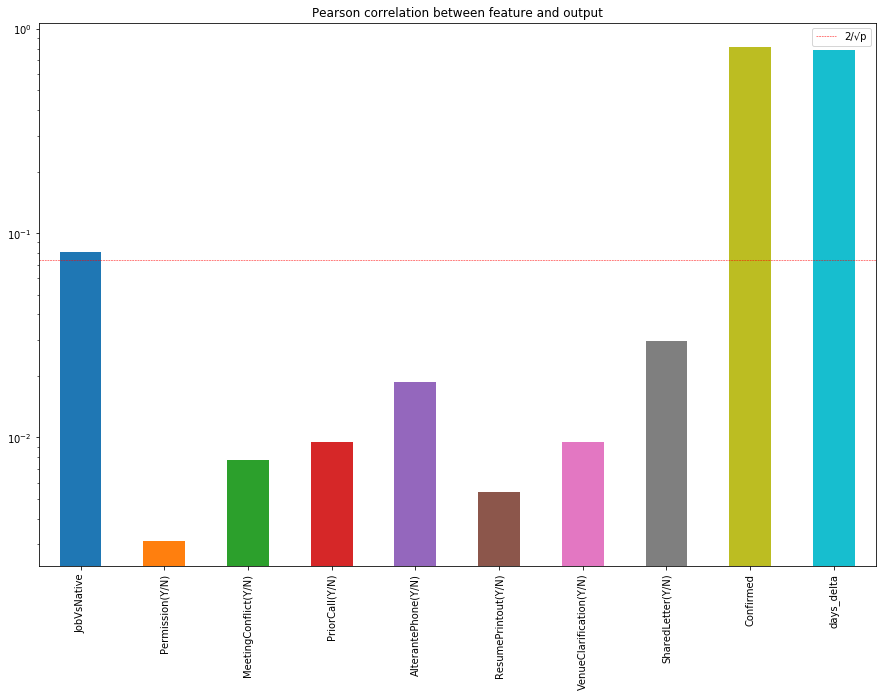

In [115]:
plt.figure(figsize=(15, 10))
plt.title("Pearson correlation between feature and output")
output_r.loc[output_r.index != "Attended", "Attended"].plot(kind="bar", label="")
tresh_line = plt.axhline(corr_tresh, linewidth=0.5, linestyle="--", color='r', label="2/√p")
plt.yscale("log")
plt.legend()
plt.show()

# Modeling

1. Logistic Regression

In [116]:
log = LogisticRegression()
model_log=log.fit(X_train,y_train)
y_pred_log=model_log.predict(X_test)

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [117]:
from sklearn.model_selection import cross_val_score
log_cv_score = cross_val_score(model_log, X, y, cv=2, scoring='roc_auc')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Logistic Regression : ", log_cv_score.mean())

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


=== Mean AUC Score ===
Mean AUC Score - Logistic Regression :  0.9989017700377605


Confusion Matrix :
 [[0.965517 0.034483]
 [0.007634 0.992366]]


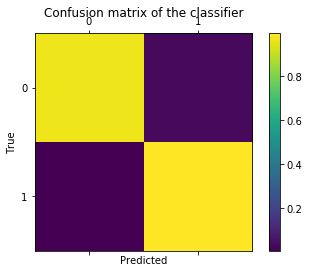

Classioficaton Report :
               precision    recall  f1-score   support

     No-Show       0.99      0.97      0.98       116
        Show       0.97      0.99      0.98       131

   micro avg       0.98      0.98      0.98       247
   macro avg       0.98      0.98      0.98       247
weighted avg       0.98      0.98      0.98       247

Precision score: 0.9701492537313433
Recall score: 0.9923664122137404
f1_score : 0.9811320754716981
fbeta_score_0.5 : 0.974512743628186
fbeta_score_1 : 0.9811320754716981
fbeta_score_2 : 0.9878419452887538
precision_recall_fscore_support : (array([0.99115 , 0.970149]), array([0.965517, 0.992366]), array([0.985915, 0.974513]), array([116, 131], dtype=int64))
Accuracy Score: 0.979757085020243
Loss: 0.020242914979757085


In [118]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_log.round())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix :\n', cm)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss
target_names = ['Absence', 'Attendance']
print('Classificaton Report :\n', classification_report(y_test, y_pred_log.round(), target_names=target_names))

from sklearn import metrics
print('Precision score:', metrics.precision_score(y_test, y_pred_log.round()))
print('Recall score:', metrics.recall_score(y_test, y_pred_log.round()))
print('f1_score :', metrics.f1_score(y_test, y_pred_log.round()))  
print('fbeta_score_0.5 :', metrics.fbeta_score(y_test, y_pred_log.round(), beta=0.5))
print('fbeta_score_1 :', metrics.fbeta_score(y_test, y_pred_log.round(), beta=1)) 
print('fbeta_score_2 :', metrics.fbeta_score(y_test, y_pred_log.round(), beta=2)) 
print('precision_recall_fscore_support :', metrics.precision_recall_fscore_support(y_test, y_pred_log.round(), beta=0.5))
print('Accuracy Score:', accuracy_score(y_test,  y_pred_log.round(), normalize=True, sample_weight=None))
print('Loss:', hamming_loss(y_test, y_pred_log.round()))

2. Random Forrest

In [130]:
rf = RandomForestClassifier(max_depth=5, n_estimators=10)
model_rf = rf.fit(X_train,y_train)
y_pred_rf = model_rf.predict(X_test)

In [131]:
from sklearn.model_selection import cross_val_score
rf_cv_score = cross_val_score(model_rf, X, y, cv=10, scoring='roc_auc')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest Classifier : ", rf_cv_score.mean())

=== Mean AUC Score ===
Mean AUC Score - Random Forest Classifier :  0.9966360792960332


Confusion Matrix :
 [[0.965517 0.034483]
 [0.007634 0.992366]]


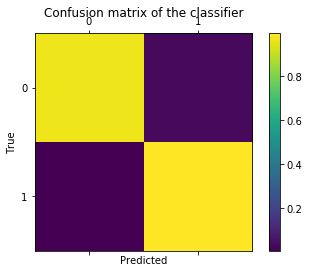

Classioficaton Report :
               precision    recall  f1-score   support

     No-Show       0.99      0.97      0.98       116
        Show       0.97      0.99      0.98       131

   micro avg       0.98      0.98      0.98       247
   macro avg       0.98      0.98      0.98       247
weighted avg       0.98      0.98      0.98       247

Precision score: 0.9701492537313433
Recall score: 0.9923664122137404
f1_score : 0.9811320754716981
fbeta_score_0.5 : 0.974512743628186
fbeta_score_1 : 0.9811320754716981
fbeta_score_2 : 0.9878419452887538
precision_recall_fscore_support : (array([0.99115 , 0.970149]), array([0.965517, 0.992366]), array([0.985915, 0.974513]), array([116, 131], dtype=int64))
Accuracy Score: 0.979757085020243
Loss: 0.020242914979757085


In [132]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_rf.round())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix :\n', cm)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss
target_names = ['Absence', 'Attendance']
print('Classificaton Report :\n', classification_report(y_test, y_pred_rf.round(), target_names=target_names))

from sklearn import metrics
print('Precision score:', metrics.precision_score(y_test, y_pred_rf.round()))
print('Recall score:', metrics.recall_score(y_test, y_pred_rf.round()))
print('f1_score :', metrics.f1_score(y_test, y_pred_rf.round()))  
print('fbeta_score_0.5 :', metrics.fbeta_score(y_test, y_pred_rf.round(), beta=0.5))
print('fbeta_score_1 :', metrics.fbeta_score(y_test, y_pred_rf.round(), beta=1)) 
print('fbeta_score_2 :', metrics.fbeta_score(y_test, y_pred_rf.round(), beta=2)) 
print('precision_recall_fscore_support :', metrics.precision_recall_fscore_support(y_test, y_pred_rf.round(), beta=0.5))
print('Accuracy Score:', accuracy_score(y_test,  y_pred_rf.round(), normalize=True, sample_weight=None))
print('Loss:', hamming_loss(y_test, y_pred_rf.round()))

3. XGBoosting

In [133]:
xgb = XGBClassifier(n_estimators=200, scale_pos_weight=((y_train == 0).sum() / y_train.sum()))
model_xgb = xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

In [134]:
from sklearn.model_selection import cross_val_score
xgb_cv_score = cross_val_score(model_xgb, X, y, cv=10, scoring='roc_auc')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest Classifier : ", xgb_cv_score.mean())

=== Mean AUC Score ===
Mean AUC Score - Random Forest Classifier :  0.9981417147931084


Confusion Matrix :
 [[0.965517 0.034483]
 [0.007634 0.992366]]


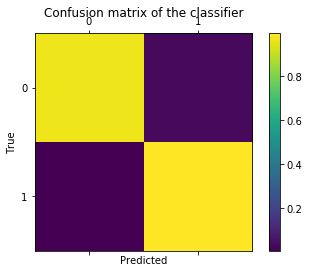

Classioficaton Report :
               precision    recall  f1-score   support

     No-Show       0.99      0.97      0.98       116
        Show       0.97      0.99      0.98       131

   micro avg       0.98      0.98      0.98       247
   macro avg       0.98      0.98      0.98       247
weighted avg       0.98      0.98      0.98       247

Precision score: 0.9701492537313433
Recall score: 0.9923664122137404
f1_score : 0.9811320754716981
fbeta_score_0.5 : 0.974512743628186
fbeta_score_1 : 0.9811320754716981
fbeta_score_2 : 0.9878419452887538
precision_recall_fscore_support : (array([0.99115 , 0.970149]), array([0.965517, 0.992366]), array([0.985915, 0.974513]), array([116, 131], dtype=int64))
Accuracy Score: 0.979757085020243
Loss: 0.020242914979757085


In [135]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_xgb.round())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix :\n', cm)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss
target_names = ['Absence', 'Attendance']
print('Classificaton Report :\n', classification_report(y_test, y_pred_xgb.round(), target_names=target_names))

from sklearn import metrics
print('Precision score:', metrics.precision_score(y_test, y_pred_xgb.round()))
print('Recall score:', metrics.recall_score(y_test, y_pred_xgb.round()))
print('f1_score :', metrics.f1_score(y_test, y_pred_xgb.round()))  
print('fbeta_score_0.5 :', metrics.fbeta_score(y_test, y_pred_xgb.round(), beta=0.5))
print('fbeta_score_1 :', metrics.fbeta_score(y_test, y_pred_xgb.round(), beta=1)) 
print('fbeta_score_2 :', metrics.fbeta_score(y_test, y_pred_xgb.round(), beta=2)) 
print('precision_recall_fscore_support :', metrics.precision_recall_fscore_support(y_test, y_pred_xgb.round(), beta=0.5))
print('Accuracy Score:', accuracy_score(y_test,  y_pred_xgb.round(), normalize=True, sample_weight=None))
print('Loss:', hamming_loss(y_test, y_pred_xgb.round()))

4. Naive Bias

In [120]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model_gnb=gnb.fit(X_train,y_train)
y_pred_gnb=model_gnb.predict(X_test)

In [121]:
from sklearn.model_selection import cross_val_score
nb_cv_score = cross_val_score(model_gnb, X, y, cv=10, scoring='roc_auc')
print("=== Mean AUC Score ===")
print("Mean AUC Score - GNb Classifier : ", nb_cv_score.mean())

=== Mean AUC Score ===
Mean AUC Score - GNb Classifier :  0.9838106806494646


Confusion Matrix :
 [[0.982759 0.017241]
 [0.099237 0.900763]]


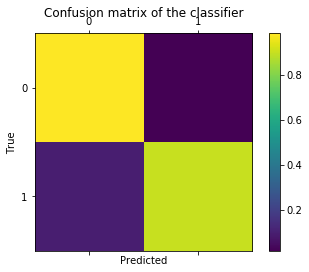

Classioficaton Report :
               precision    recall  f1-score   support

     Absence       0.90      0.98      0.94       116
  Attendance       0.98      0.90      0.94       131

   micro avg       0.94      0.94      0.94       247
   macro avg       0.94      0.94      0.94       247
weighted avg       0.94      0.94      0.94       247

Precision score: 0.9833333333333333
Recall score: 0.9007633587786259
f1_score : 0.940239043824701
fbeta_score_0.5 : 0.9656301145662847
fbeta_score_1 : 0.940239043824701
fbeta_score_2 : 0.9161490683229812
precision_recall_fscore_support : (array([0.897638, 0.983333]), array([0.982759, 0.900763]), array([0.913462, 0.96563 ]), array([116, 131], dtype=int64))
Accuracy Score: 0.9392712550607287
Loss: 0.06072874493927125


In [152]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_gnb.round())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix :\n', cm)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss
target_names = ['Absence', 'Attendance']
print('Classificaton Report :\n', classification_report(y_test, y_pred_gnb.round(), target_names=target_names))

from sklearn import metrics
print('Precision score:', metrics.precision_score(y_test, y_pred_gnb.round()))
print('Recall score:', metrics.recall_score(y_test, y_pred_gnb.round()))
print('f1_score :', metrics.f1_score(y_test, y_pred_gnb.round()))  
print('fbeta_score_0.5 :', metrics.fbeta_score(y_test, y_pred_gnb.round(), beta=0.5))
print('fbeta_score_1 :', metrics.fbeta_score(y_test, y_pred_gnb.round(), beta=1)) 
print('fbeta_score_2 :', metrics.fbeta_score(y_test, y_pred_gnb.round(), beta=2)) 
print('precision_recall_fscore_support :', metrics.precision_recall_fscore_support(y_test, y_pred_gnb.round(), beta=0.5))
print('Accuracy Score:', accuracy_score(y_test,  y_pred_gnb.round(), normalize=True, sample_weight=None))
print('Loss:', hamming_loss(y_test, y_pred_gnb.round()))

# ROC Curves

In [136]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

In [137]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
log = LogisticRegression()
log.fit(X_train, y_train)
#y_pred_log = model_log.predict_proba(test_dataset)[:, 1]
y_pred_log = log.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_pred_log)
auc_log = auc(fpr_log, tpr_log)

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [138]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict_proba(X_test)[:, 1]
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, y_pred_gnb)
auc_gnb = auc(fpr_gnb, tpr_gnb)

In [139]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
nsamples, nx = X_train.shape
nsamplesx, nxx = X_test.shape
#train_dataset = X_train.reshape((nsamples,nx))
#test_dataset = X_test.reshape((nsamplesx,nxx))

rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

<Figure size 432x288 with 0 Axes>

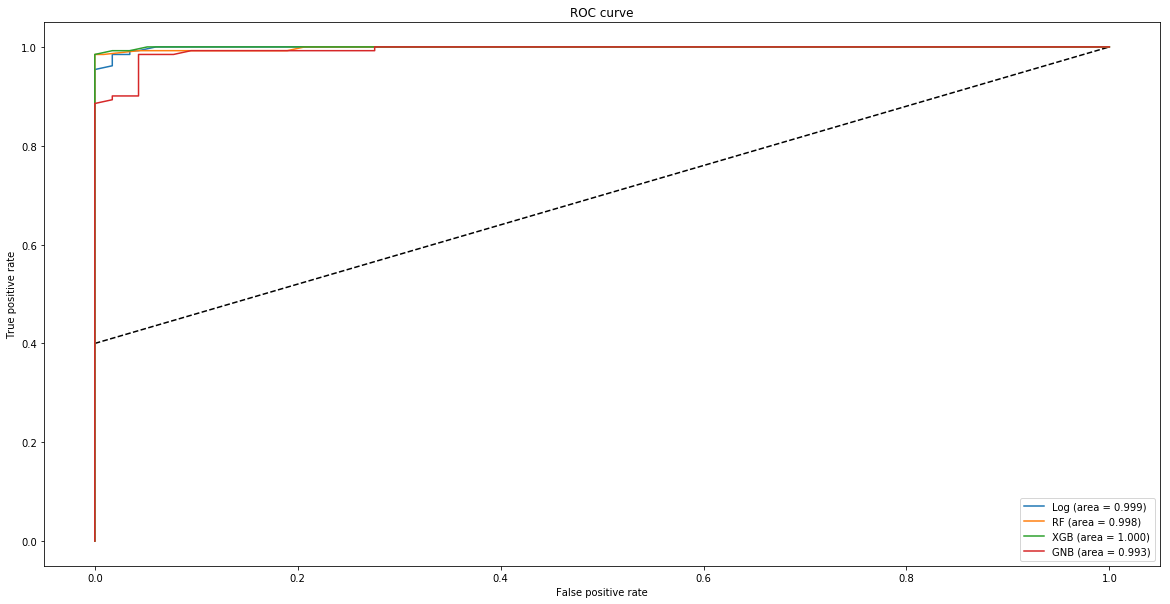

<Figure size 432x288 with 0 Axes>

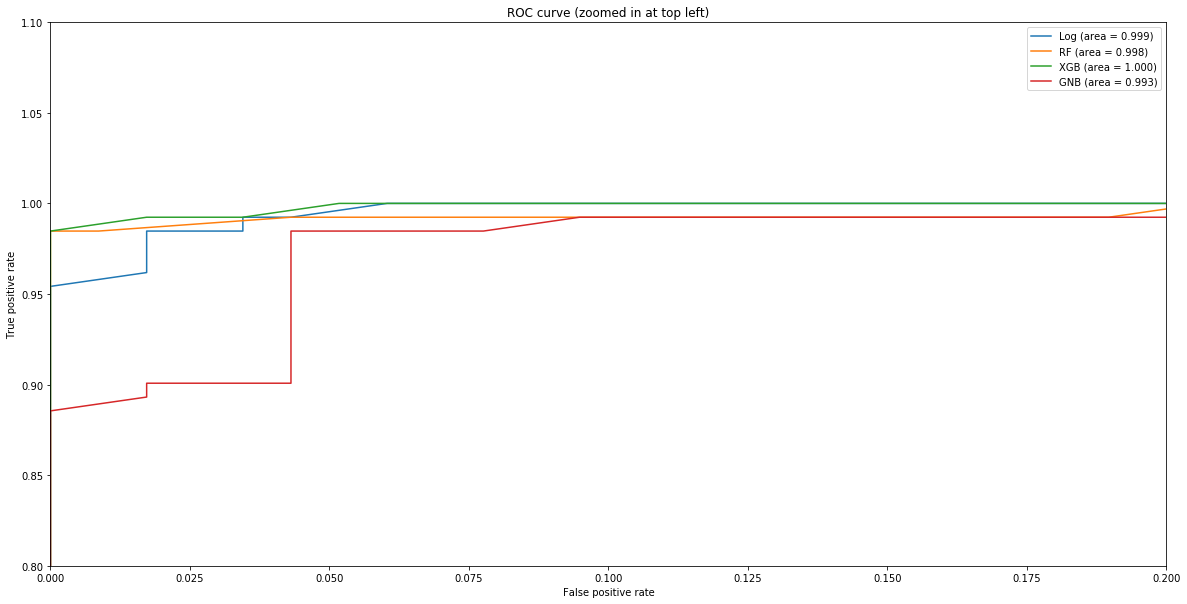

In [140]:
plt.figure(1)
plt.figure(figsize= (20, 10))
plt.plot([0, 1], [0.4, 1], 'k--')
plt.plot(fpr_log, tpr_log, label='Log (area = {:.3f})'.format(auc_log))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGB (area = {:.3f})'.format(auc_xgb))
plt.plot(fpr_gnb, tpr_gnb, label='GNB (area = {:.3f})'.format(auc_gnb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.figure(figsize= (20, 10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_log, tpr_log, label='Log (area = {:.3f})'.format(auc_log))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGB (area = {:.3f})'.format(auc_xgb))
plt.plot(fpr_gnb, tpr_gnb, label='GNB (area = {:.3f})'.format(auc_gnb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

# Predict

In [141]:
one_hot_features

Index(['JobVsNative', 'Permission(Y/N)', 'MeetingConflict(Y/N)',
       'PriorCall(Y/N)', 'AlterantePhone(Y/N)', 'ResumePrintout(Y/N)',
       'VenueClarification(Y/N)', 'SharedLetter(Y/N)', 'Confirmed',
       'days_delta'],
      dtype='object')

In [142]:
model_log = rf.fit(X_train.as_matrix(), y_train.as_matrix())
model_log.predict_proba(X_val.as_matrix()[13].reshape(1, 10))

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0.02969, 0.97031]])

In [143]:
model_xgb = xgb.fit(X_train.as_matrix(), y_train.as_matrix())
model_xgb.predict_proba(X_val.as_matrix()[13].reshape(1, 10))

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0.001093, 0.998907]], dtype=float32)

In [144]:
model_rf = rf.fit(X_train.as_matrix(), y_train.as_matrix())
model_rf.predict_proba(X_val.as_matrix()[13].reshape(1, 10))

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0.150234, 0.849766]])

In [145]:
model_gnb = gnb.fit(X_train.as_matrix(), y_train.as_matrix())
model_gnb.predict_proba(X_val.as_matrix()[13].reshape(1, 10))

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[3.254660e-04, 9.996745e-01]])

In [150]:
inp = np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 10])
model_rf.predict_proba(inp.reshape(1, 10))

array([[0.313106, 0.686894]])

# Generate pickle file with RFClassifier

In [153]:
#Saving the model to disk
pickle.dump(model_rf, open('model.pkl', 'wb'))

#Loading model to compare the results
model = pickle.load(open('model.pkl', 'rb'))

In [171]:
inp = np.array([0, 1, 1, 1, 1, 1, 1, 1, 0, 5]).reshape(1, 10)

In [172]:
model.predict_proba(inp)[0][1]

0.45391405074499047